In [2]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from scipy.stats import beta
from scipy.stats import gumbel_r
from scipy.optimize import curve_fit

In [3]:
# damage ratios dataset
df = pd.read_csv('DAMAGE_RATIOS.csv')

In [4]:
# Drop NaNs
df = df.dropna()

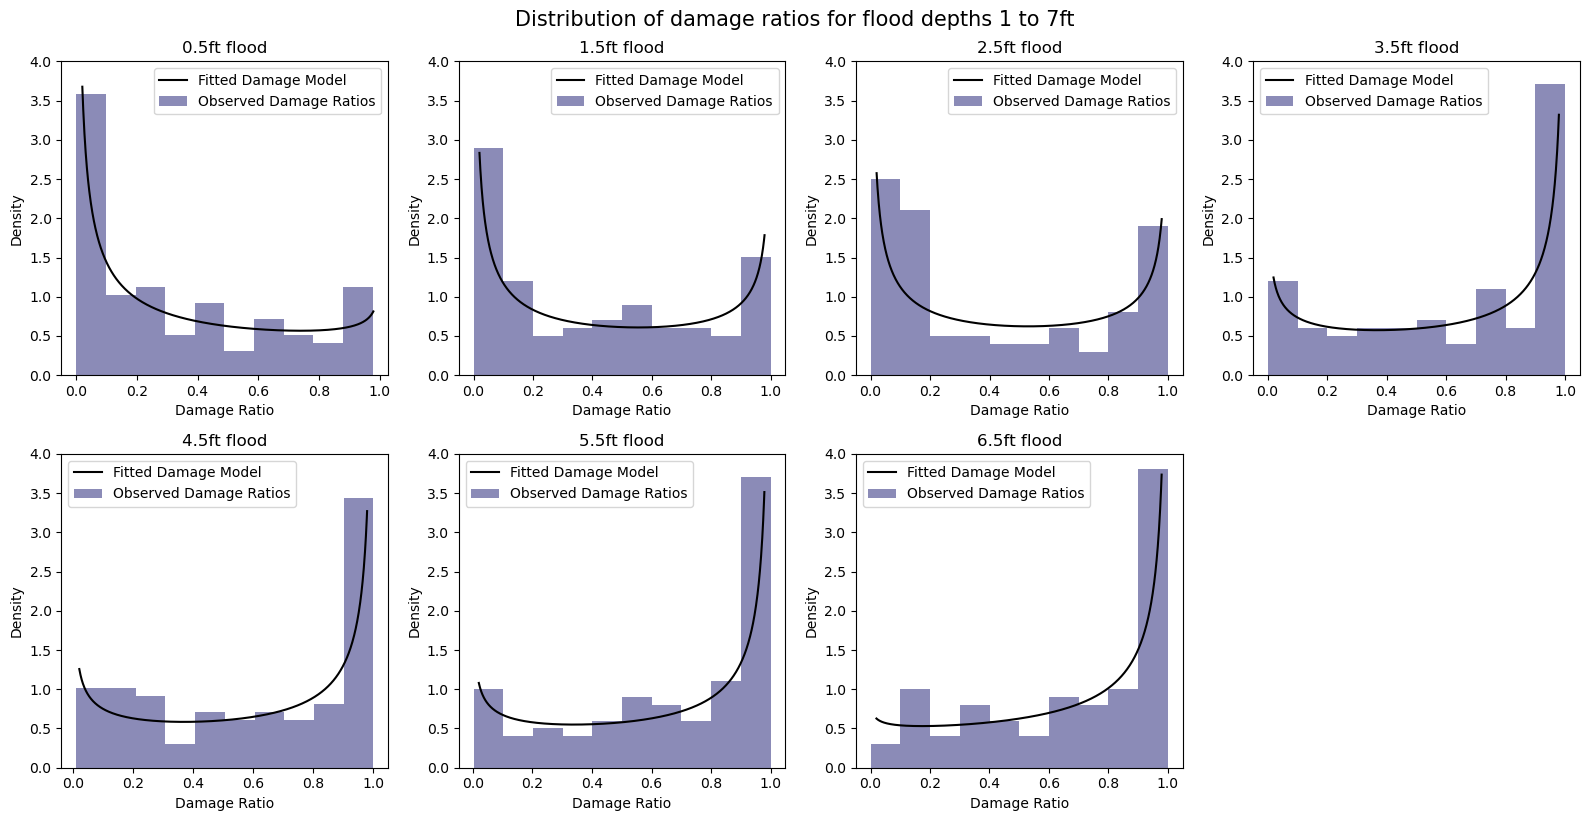

In [5]:
# Plotting damage ratios with fitted beta distributions
plt.figure(figsize = (16,8))
ex = np.arange(0.02,0.98,0.001)
params = np.zeros((7,4)) # INitializing params array for each flood depth
for i,x in enumerate(df.columns):
    plt.subplot(2,4,i+1)
    plt.hist(df[x], density = True, color = 'midnightblue', alpha = 0.5)
    plt.xlabel('Damage Ratio')
    plt.ylabel('Density')
    plt.title(f'{i+0.5}ft flood')
    a,b,loc,scale = beta.fit(df[x], floc = 0, fscale = 1.0001)
    y = beta.pdf(ex,a,b,loc,scale)
    plt.plot(ex,y, 'k-')
    plt.ylim(0,4)
    plt.legend(['Fitted Damage Model','Observed Damage Ratios'])
    params[i,:] = [a,b,loc,scale] # saving params of beta distribution in params array
plt.tight_layout()
plt.suptitle('Distribution of damage ratios for flood depths 1 to 7ft', y = 1.02, fontsize = 15)

plt.savefig('damage.png', transparent = True)

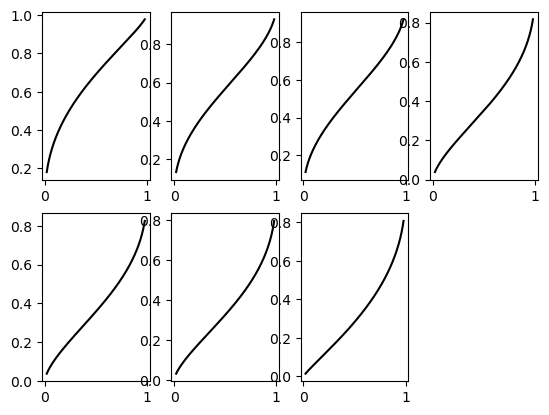

In [6]:
for i,x in enumerate(df.columns):
    plt.subplot(2,4,i+1)
    a,b,loc,scale = beta.fit(df[x], floc = 0, fscale = 1.0001)
    y = beta.cdf(ex,a,b,loc,scale)
    plt.plot(ex,y, 'k-')
    

In [7]:
# Estimating damages over 10000 properties using Monte Carlo simulation

mean_damage = np.zeros((1,7)) # Initialise mean damage array
damages = np.zeros((10_000,7)) # Initialise damage array for 10000 properties and 7 flood depths
for i in range(7):
    np.random.seed(60)
    x = np.random.rand(10000) # 10000 pseudo random numbers
    icdf = beta.ppf(x,params[i,0],params[i,1], params[i,2], params[i,3]) # Inverse CDF function to get damage ratios from fitted beta distribution
    damage = icdf*500_000 # Total simulated damages for 10,000 homes in USD
    damages[:,i] = damage
    mean_damage[0,i] = damage.mean()


In [8]:
insurance_payoff_B = ((damages >= 50_000)&(damages <= 300_000))*(damages - 50_000) + (damages >300_000)*250_000

In [9]:
# Cost of damages after purchasing insurance
# Calculating insurance costs and payoff
# Annual premiums of each insurance
premium_B = 0.8*1500
premium_A = 1500
premium_C = 0.6*1500
ded_A = 1250
ded_B = 5000
ded_C = 10000
premiums = np.array([0, premium_A, premium_B, premium_C])

# Damages covered by insurance for each insurance for 10,000 homes for each flood depth
insurance_payoff_A = ((damages >= ded_A)&(damages <= 250_000))*(damages-ded_A) + (damages > 250_000)*250_000
insurance_payoff_B = ((damages >= ded_B)&(damages <= 250_000))*(damages - ded_B) + (damages >250_000)*250_000
insurance_payoff_C = ((damages >= ded_C)&(damages <= 250_000))*(damages - ded_C) + (damages >250_000)*250_000

# Cost to homeowner after purchasing insurance for 10,000 homes for each flood depth
insured_cost_B = damages - insurance_payoff_B 
insured_cost_A = damages - insurance_payoff_A 
insured_cost_C = damages - insurance_payoff_C 

# Mean cost of homeowner after purchasing insurance for each flood depth
mean_insured_cost_B = insured_cost_B.mean(axis = 0)
mean_insured_cost_A = insured_cost_A.mean(axis = 0)
mean_insured_cost_C = insured_cost_C.mean(axis = 0)

In [10]:
depth_flow = {0:132284,1:143307,2:171969,3:200738,4:234567,5:240196,6:243949}
g_loc = 80156.190 # Location param for gumbel distribution of annual max streamflows
g_scale = 20200.864 # Scale param for gumbel distribution of annual max streamflows
depths = np.arange(0.5, 7, 1)
flows = list(depth_flow.values())

In [11]:
flows

[132284, 143307, 171969, 200738, 234567, 240196, 243949]

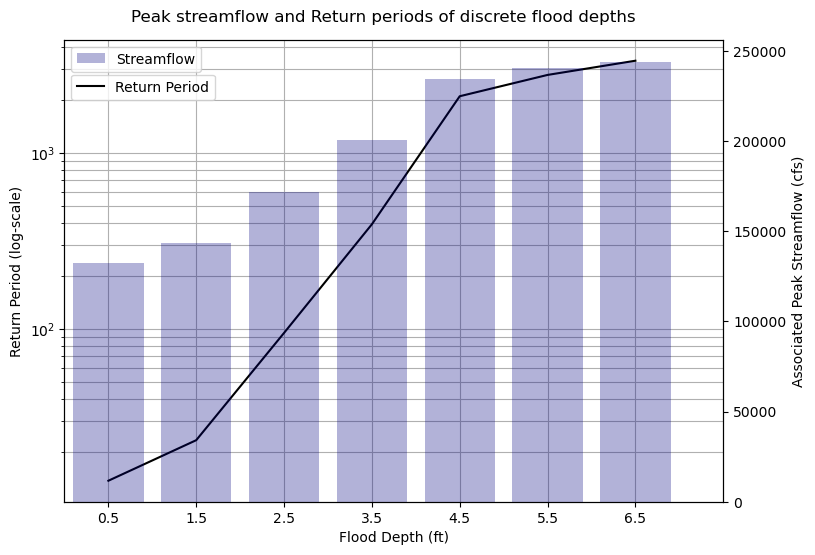

In [12]:
returns = 1/gumbel_r.sf(flows, loc = g_loc, scale = g_scale)

str_flows = [str(x) for x in flows]
fig, ax1 = plt.subplots(figsize = (8.5,6))
plt.grid(which = 'both')
ax2 = ax1.twinx()
ax2.bar(x = depths, height = flows, color = 'navy', alpha = 0.3)
ax2.set_ylabel('Associated Peak Streamflow (cfs)')
ax1.semilogy(depths, returns, 'k')
ax1.set_xticks(depths)
ax1.set_xlabel('Flood Depth (ft)')
ax1.set_ylabel('Return Period (log-scale)')
ax1.legend(['Return Period'], loc = (0.01,0.87))
ax2.legend(['Streamflow'])
ax1.set_xlim(0, 7.5)

plt.suptitle('Peak streamflow and Return periods of discrete flood depths', y = 0.93)
plt.savefig('returns.png', transparent = True)

In [13]:
str_flows

['132284', '143307', '171969', '200738', '234567', '240196', '243949']

In [14]:
# Exceedance probability of each streamflow corresponding to flood depth
exceedance = np.array([gumbel_r.sf(depth_flow[i], loc = g_loc, scale = g_scale) for i in range(7)]).reshape(7,1)

# Annual average loss per homeowner
annual_average_loss = float(np.dot(mean_damage, exceedance)) # without insurance
annual_average_loss_insurance_A = float(np.dot(mean_insured_cost_A, exceedance)) # with insurance A
annual_average_loss_insurance_B = float(np.dot(mean_insured_cost_B, exceedance)) # with insurance B
annual_average_loss_insurance_C = float(np.dot(mean_insured_cost_C, exceedance)) # with insurance C


In [15]:
annual_average_losses = [annual_average_loss,annual_average_loss_insurance_C,annual_average_loss_insurance_B, annual_average_loss_insurance_A ]
annual_average_losses = np.array(annual_average_losses) + premiums
annual_average_losses

array([25257.4623872 ,  9057.54406781,  8433.50069013,  7869.24129703])

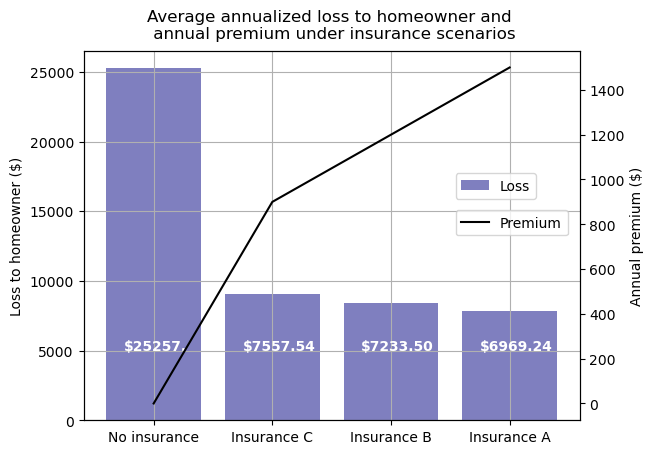

In [32]:
fig, ax1 = plt.subplots()
ax1.grid()
ax1.bar(x = np.arange(4), height = annual_average_losses, color = 'navy', alpha = 0.5)
plt.xticks(np.arange(4), ['No insurance', 'Insurance C', 'Insurance B', 'Insurance A'])
plt.text(-0.25,5000, '$'+str(annual_average_loss)[:6], color = 'white', weight = 'bold')
plt.text(0.75,5000, '$'+str(annual_average_loss_insurance_C)[:7], color = 'white', weight = 'bold')
plt.text(1.75,5000, '$'+str(annual_average_loss_insurance_B)[:7], color = 'white', weight = 'bold')
plt.text(2.75,5000, '$'+str(annual_average_loss_insurance_A)[:7], color = 'white', weight = 'bold')

ax2 = ax1.twinx()
ax2.plot(np.arange(4), [0, premium_C, premium_B, premium_A], 'k-')
ax2.set_ylabel('Annual premium ($)')
ax1.set_ylabel('Loss to homeowner ($)')
ax2.legend(['Premium'], loc = (0.75,0.5))
ax1.legend(['Loss'], loc = (0.75,0.6))
plt.title('Average annualized loss to homeowner and \n annual premium under insurance scenarios', y = 1.01)
plt.savefig('returns.png', transparent = True)

In [257]:
nums = np.arange(0,1,0.001)
isf = gumbel_r.isf(nums, loc = g_loc, scale = g_scale)

Text(0, 0.5, 'Streamflow (cfs)')

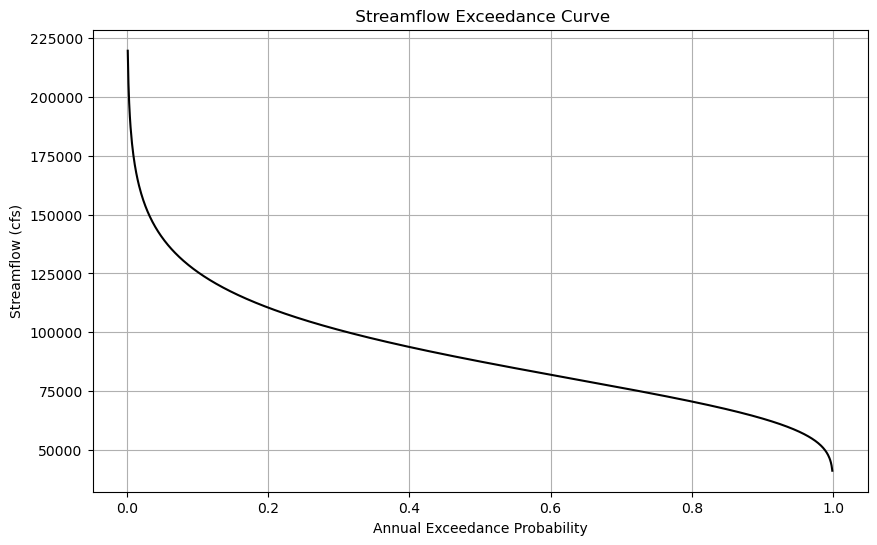

In [258]:
plt.figure(figsize = (10,6))
plt.grid()
plt.plot(nums, isf, color = 'k')
plt.title(' Streamflow Exceedance Curve')
plt.xlabel('Annual Exceedance Probability')
plt.ylabel('Streamflow (cfs)')

Text(0.5, 1.0, '')

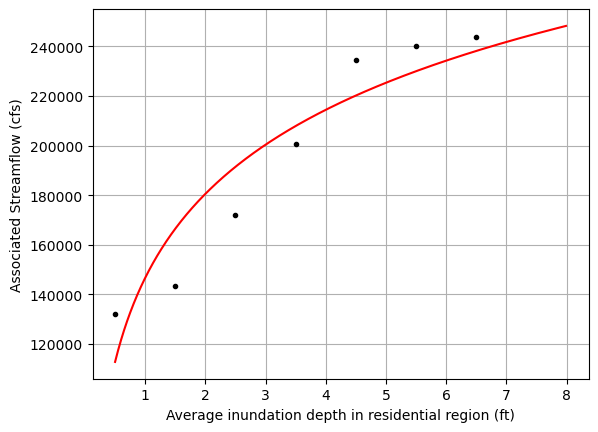

In [259]:
def df(depth):
    return 48895.1*np.log(20.0741*depth)


x = np.arange(0.5, 8, 0.01)
y = df(x)
plt.grid()
plt.plot(x,y, 'r')
plt.plot(depths, flows, '.k')
plt.xlabel('Average inundation depth in residential region (ft)')
plt.ylabel('Associated Streamflow (cfs)')
plt.title('')

In [260]:
from seaborn import kdeplot
from seaborn import heatmap

In [261]:
def kde(data, label):
    plt.figure(figsize = (12,6))
    for i in range(7):
        plt.subplot(2,4,i+1)
        kdeplot(data[:,i], label = label, fill = True, color = 'midnightblue')
        plt.xlim(0,600_000)
        plt.xticks(np.arange(0,700000,200000))
        plt.title(f'{i+0.5}ft Flood')    
        plt.tight_layout()
        plt.xlabel('Cost to homeowner ($)')
        plt.ylabel('Probability Density')
    plt.suptitle(label, y = 1)

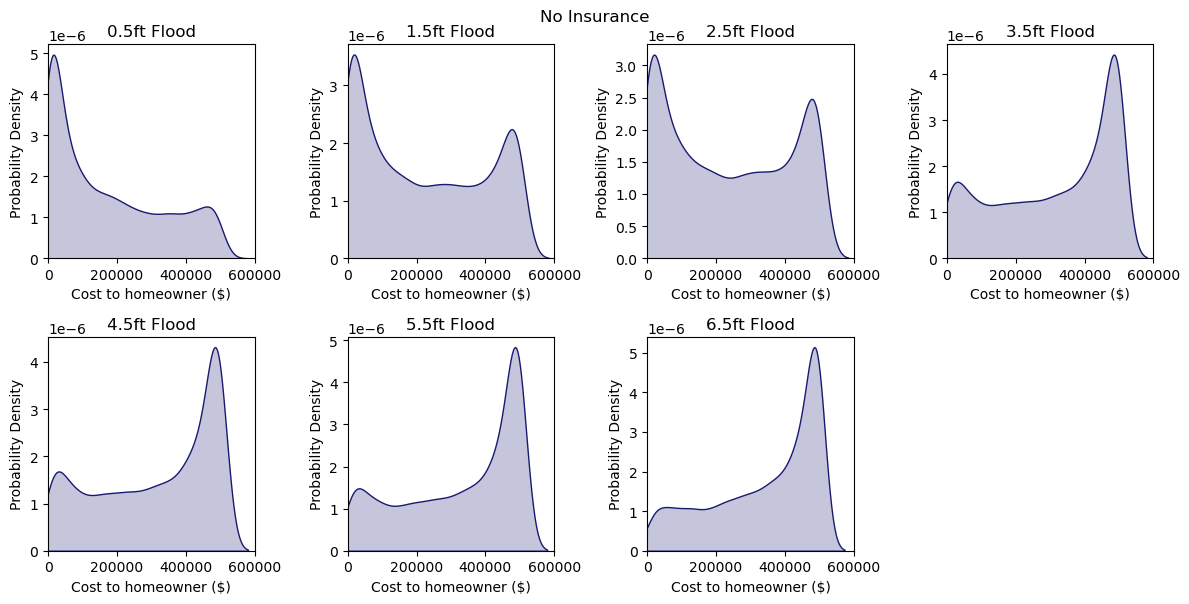

In [262]:
kde(damages, 'No Insurance')


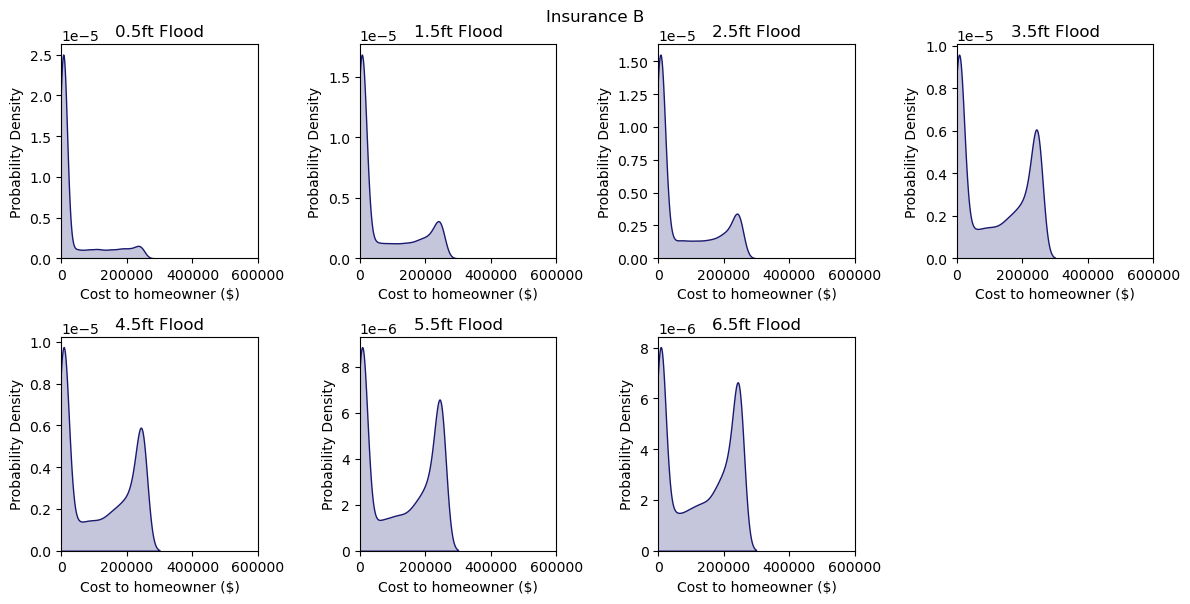

In [263]:
kde(insured_cost_B + premium_B, 'Insurance B')

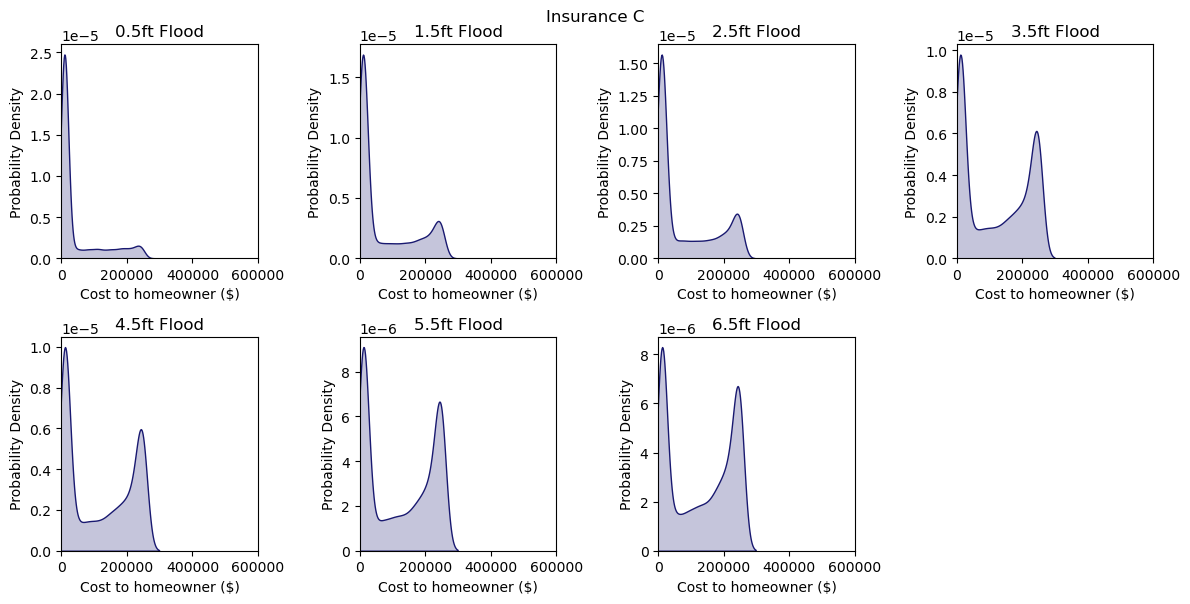

In [264]:
kde(insured_cost_C + premium_C, 'Insurance C')

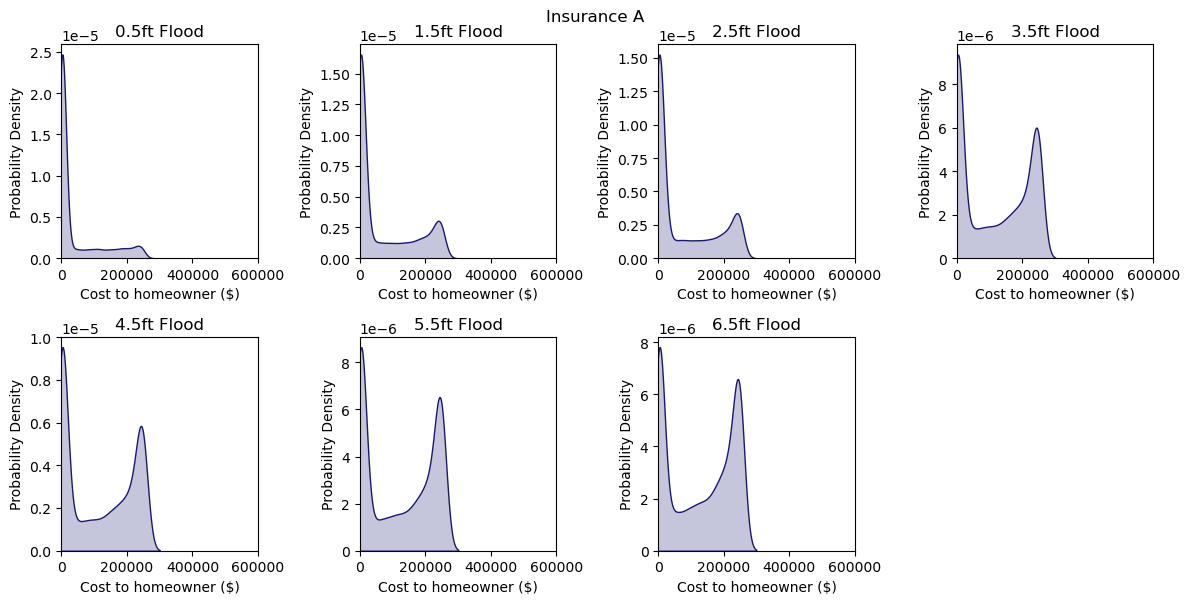

In [265]:
kde(insured_cost_A + premium_A, 'Insurance A')

In [266]:
mean_insured_cost_A = insured_cost_A.mean(axis = 0)
mean_insured_cost_B = insured_cost_B.mean(axis = 0)
mean_insured_cost_C = insured_cost_C.mean(axis = 0)
damages_cost = damages.mean(axis = 0)
mean_insured_costs = np.zeros((4,7))
mean_costs = [damages_cost, mean_insured_cost_C, mean_insured_cost_B , mean_insured_cost_A]
for i,x in enumerate(mean_costs):
    mean_insured_costs[i,:] = x

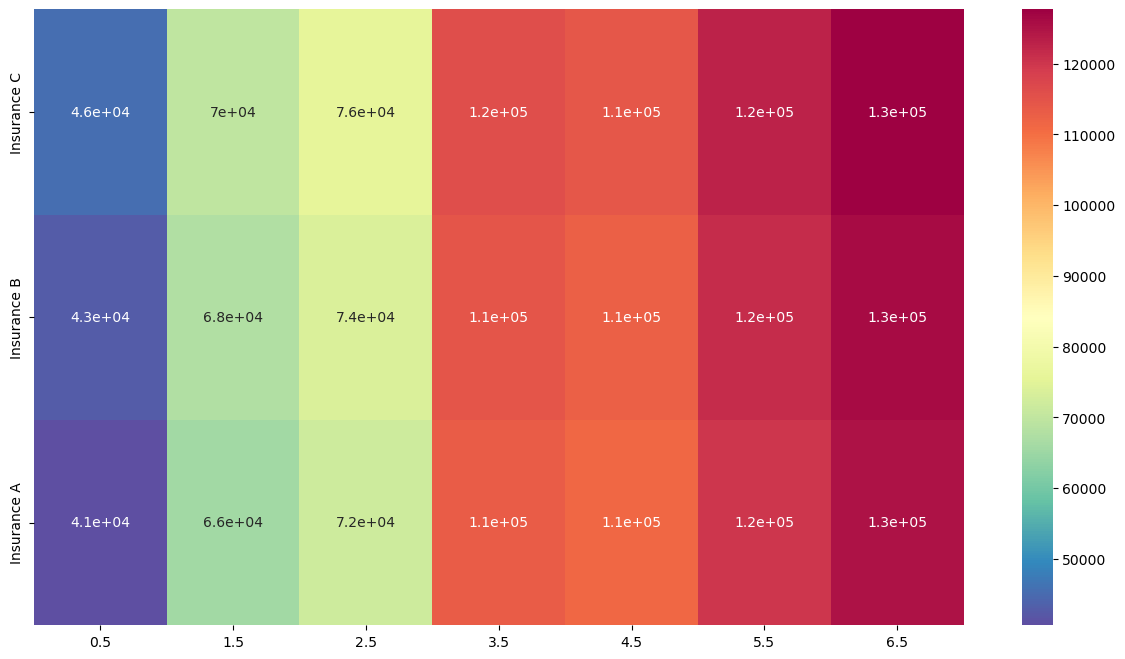

In [267]:
plt.figure(figsize = (15,8))
heatmap(mean_insured_costs[1:,:], cmap = 'Spectral_r', annot = True)
plt.xticks(np.arange(0.5,7.5), depths)
plt.yticks([0.5,1.5,2.5], ['Insurance C', 'Insurance B', 'Insurance A'])
plt.savefig('avgCosts.png', transparent = True)

In [268]:
expected_cost_A = insured_cost_A@exceedance
expected_cost_B = insured_cost_B@exceedance
expected_cost_C = insured_cost_C@exceedance
expected_cost = damages@exceedance

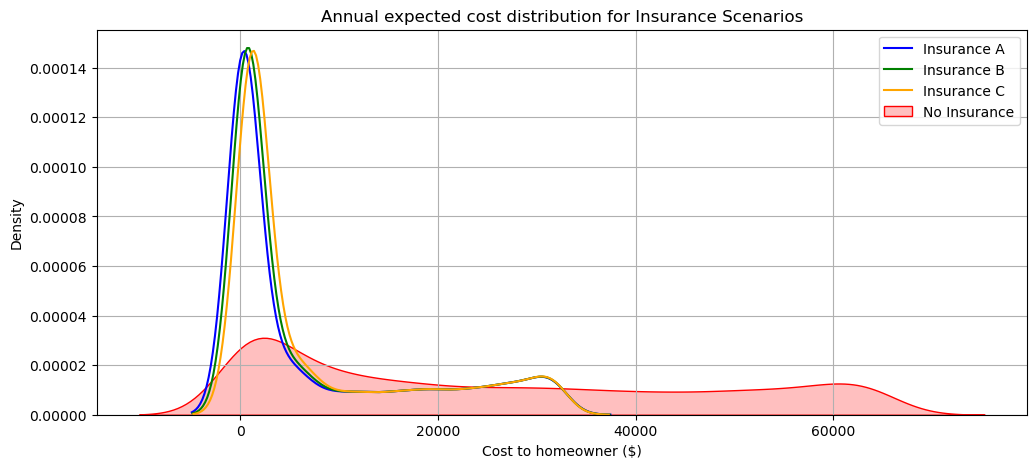

In [275]:
plt.figure(figsize = (12,5))
plt.grid()
kdeplot(expected_cost_A.squeeze(), fill = False, color = 'blue', label = 'Insurance A')
kdeplot(expected_cost_B.squeeze(), fill = False, color = 'green', label = 'Insurance B')
kdeplot(expected_cost_C.squeeze(), fill = False, color = 'orange', label = 'Insurance C')
kdeplot(expected_cost.squeeze(), fill = True, color = 'red', label = 'No Insurance')
plt.xlabel('Cost to homeowner ($)')
plt.legend()
plt.title('Annual expected cost distribution for Insurance Scenarios')
plt.savefig('simulatedAnnual.png', transparent = True)